In [5]:
# Normalise features
# Find the optimal parameters C (inverse regulalisation strengths)
# Find the best features to predict stock movement (up or down)
# Convert probability into absolute values (stock % increase/decrease)
# SVC, RandomForest, MinMax, LongShortTermMemory

%matplotlib inline
%pylab inline

# Nice Formatting within Jupyter Notebook
%matplotlib inline
from IPython.display import display # Allows multiple displays from a single code-cell
from jupyterthemes import jtplot

#import classes
from company import Company
from onestep_baseline_company import OneStepBaselineCompany
from onestep_lstm_company import OneStepLSTMCompany
from multistep_baseline_company import MultiStepBaselineCompany
from multistep_lstm_company import MultiStepLSTMCompany

jtplot.style(theme='grade3')
jtplot.style(theme='grade3')
jtplot.style(theme='grade3')

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Populating the interactive namespace from numpy and matplotlib


D:\Softwares\Miniconda3\envs\Hons\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,12.977868,35.294117,24.590164,52.727295,66.666664,0.229001,0.000000,0.0,14.889337
2,14.889337,36.764706,24.590164,52.727295,66.666664,0.381099,0.000000,0.0,15.995976
3,15.995976,42.647057,22.950821,54.545410,66.666664,0.533197,0.000000,0.0,18.209255
4,18.209255,48.529411,22.950821,56.363647,66.666664,0.839101,3.703704,0.0,13.883300
5,13.883300,48.529411,22.950821,56.363647,66.666664,0.991199,7.407407,0.0,10.965796


(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 3s - loss: 8.0928 - val_loss: 6.7840
Epoch 2/50
 - 1s - loss: 6.6425 - val_loss: 6.0237
Epoch 3/50
 - 0s - loss: 5.8074 - val_loss: 5.2169
Epoch 4/50
 - 0s - loss: 5.0350 - val_loss: 4.5131
Epoch 5/50
 - 1s - loss: 4.3622 - val_loss: 4.0141
Epoch 6/50
 - 0s - loss: 3.8859 - val_loss: 3.6968
Epoch 7/50
 - 0s - loss: 3.5519 - val_loss: 3.5165
Epoch 8/50
 - 0s - loss: 3.2755 - val_loss: 3.5225
Epoch 9/50
 - 0s - loss: 3.0781 - val_loss: 3.3852
Epoch 10/50
 - 0s - loss: 2.9193 - val_loss: 3.3130
Epoch 11/50
 - 0s - loss: 2.7777 - val_loss: 3.4079
Epoch 12/50
 - 1s - loss: 2.6520 - val_loss: 3.3529
Epoch 13/50
 - 1s - loss: 2.5679 - val_loss: 3.3610
Epoch 14/50
 - 0s - loss: 2.5078 - val_loss: 3.2990
Epoch 15/50
 - 0s - loss: 2.4391 - val_loss: 3.3931
Epoch 16/50
 - 0s - loss: 2.3867 - val_loss: 3.3502
Epoch 17/50
 - 0s - loss: 2.3057 - val_loss: 3.4074
Epoch 18/50
 - 0s - loss: 2.2580

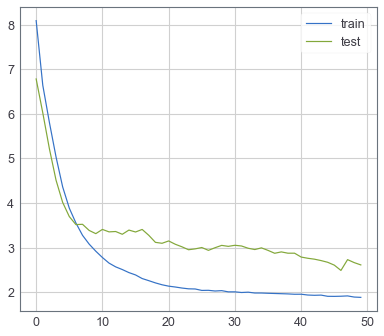

Test RMSE: 42.247


In [31]:
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
display(dataset)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
display(values)
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
display(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [32]:
display(reframed.describe())

#mod = reframed.drop(['var8(t+2)', "var7(t+2)"], axis=1)
#display(mod)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
count,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000
mean,9.458289,61.513287,51.572781,46.267101,55.451038,4.005665,0.195421,0.541742,9.458020
std,9.280935,21.219233,19.989016,18.674883,31.267904,8.546808,2.817003,3.934064,9.281004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.414487,44.117645,34.426231,30.909058,33.333332,0.229001,0.000000,0.000000,2.414487
50%,6.841046,61.764706,54.098358,45.454590,66.666664,0.840810,0.000000,0.000000,6.841046
75%,13.329980,80.882355,68.852463,61.818237,66.666664,3.667436,0.000000,0.000000,13.329980
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
